In [1]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from utils.skeleton_utils import get_endpoints, get_branching_points, get_crossing_points

# %matplotlib ipympl

In [3]:
# Load binary skeltonised instances from png file
def load_skeltonised_mask_from_png(file_path):
    # Load image
    img = Image.open(file_path)
    img = img.convert('L')
    img = np.array(img)

    # Convert to binary
    img = (img > 0).astype(np.uint8)

    return img

skeletonised_mask = load_skeltonised_mask_from_png('../sample_data/skeletonised_masks/exp1_block1_pot31_4_skeletonised_mask.png')

In [11]:
# load original image so that we can overlay the skeleton on top of it
original_image = Image.open('../datasets/niab/EXP01/Top_Images/Top_Images_Clean_Rename/EXP01_Block01/EXP01_Block01_Rename05_20201202/Exp01_Block01_Image05_Pot031.jpg')

# resize the original image to match the skeletonised mask
original_image = original_image.resize((skeletonised_mask.shape[1], skeletonised_mask.shape[0]))

Number of endpoints: 62
Number of branching points: 26
Number of crossing points: 16


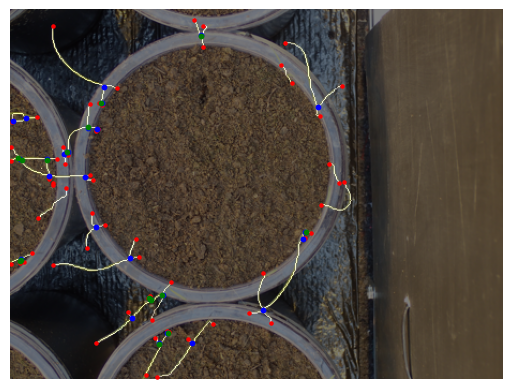

In [13]:
# Get endpoints, branching points and crossing points
endpoints = get_endpoints(skeletonised_mask)
branching_points = get_branching_points(skeletonised_mask)
crossing_points = get_crossing_points(skeletonised_mask)

print(f'Number of endpoints: {endpoints.shape[0]}')
print(f'Number of branching points: {branching_points.shape[0]}')
print(f'Number of crossing points: {crossing_points.shape[0]}')


# Display the skeleomised mask with the points
plt.figure()
plt.imshow(skeletonised_mask, cmap='gray')
plt.imshow(original_image, alpha=0.5)
plt.scatter(endpoints[:, 1], endpoints[:, 0], c='r', s=5)
plt.scatter(branching_points[:, 1], branching_points[:, 0], c='b', s=10)
plt.scatter(crossing_points[:, 1], crossing_points[:, 0], c='g', s=10)
# no axis
plt.axis('off')
plt.show()


35


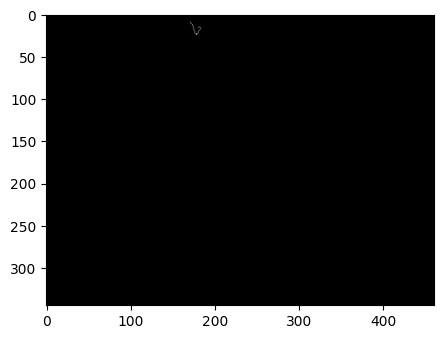

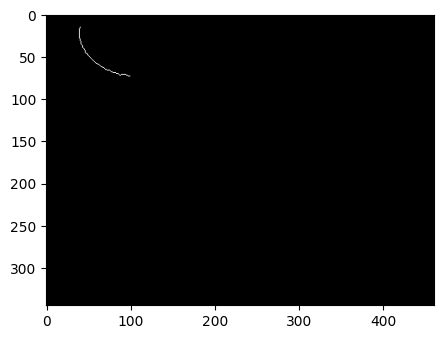

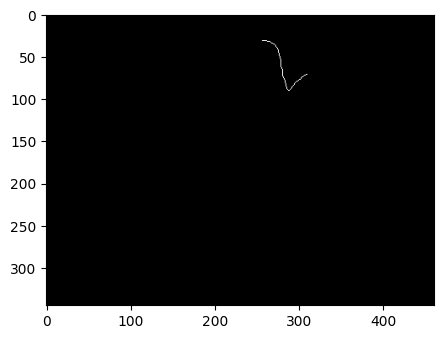

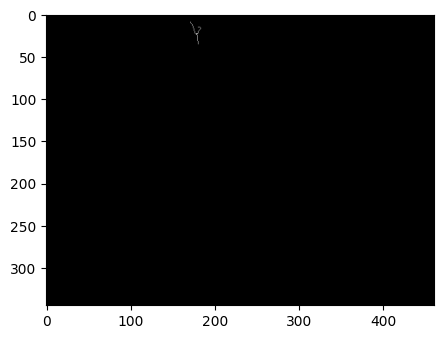

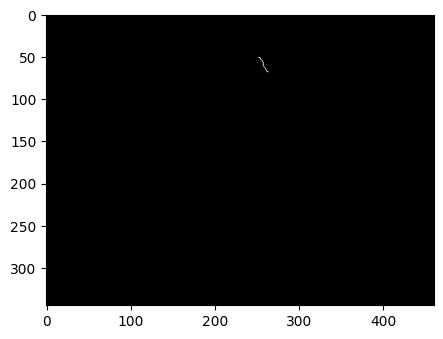

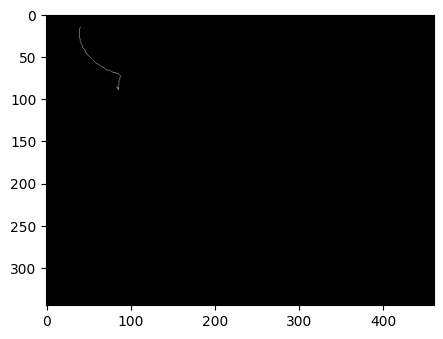

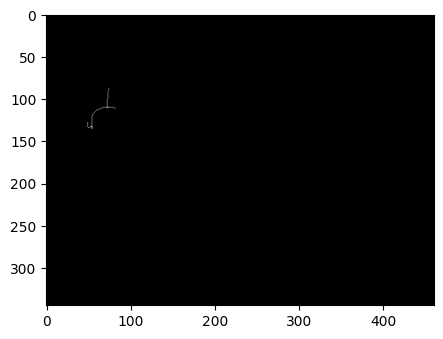

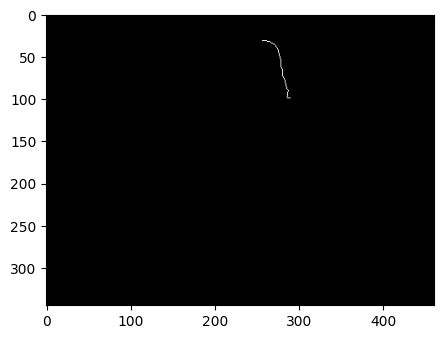

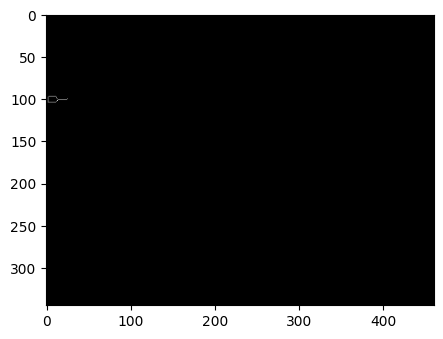

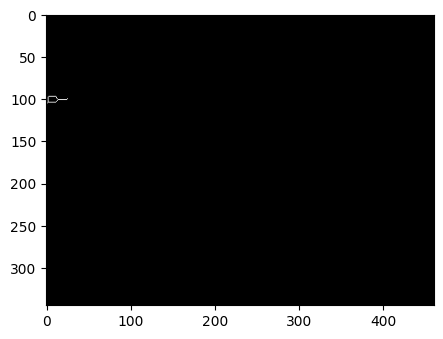

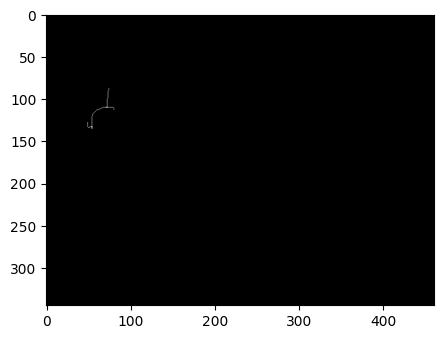

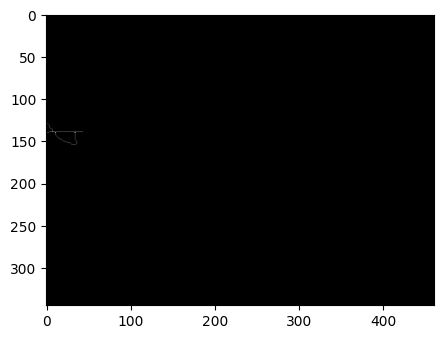

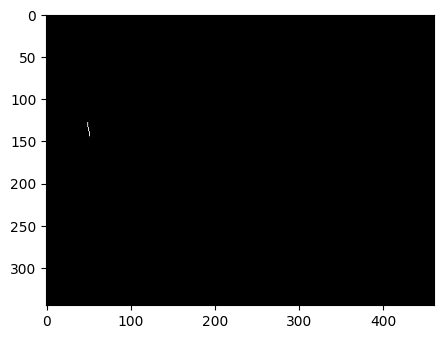

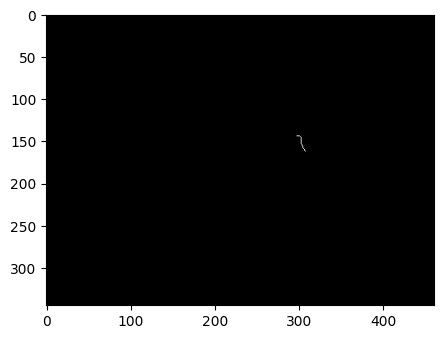

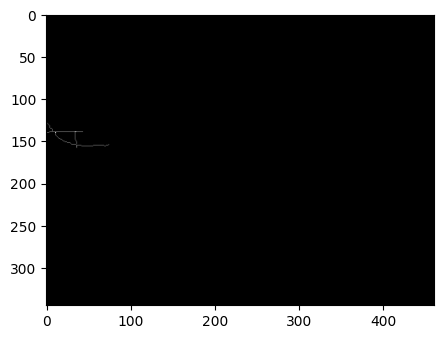

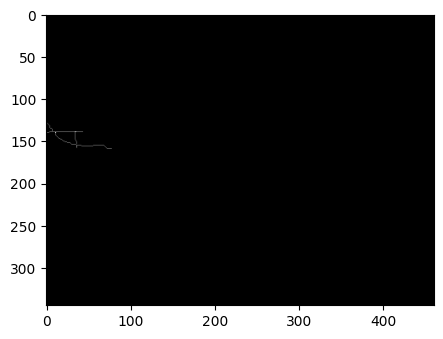

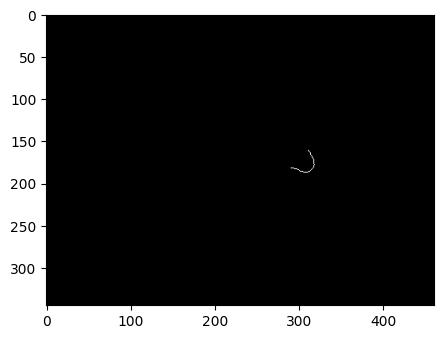

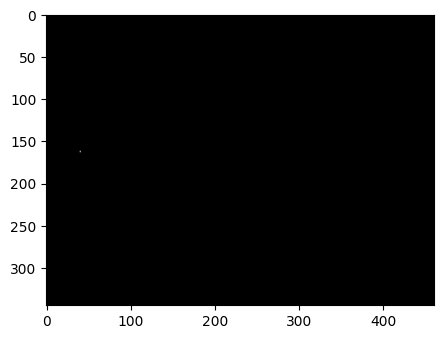

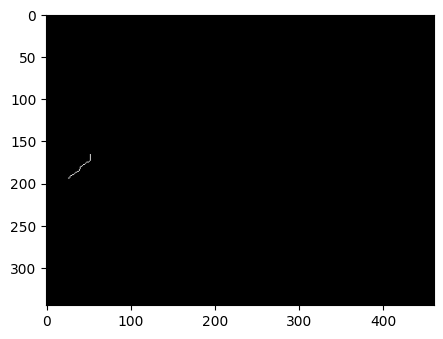

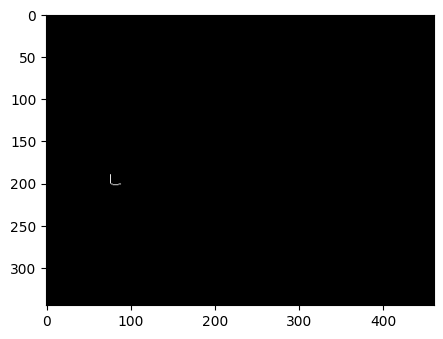

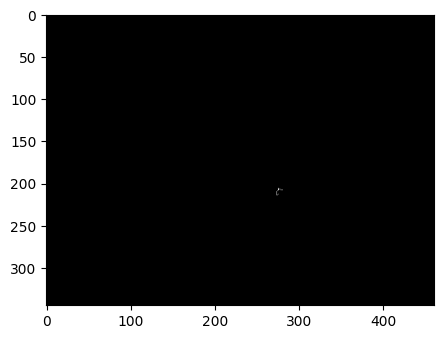

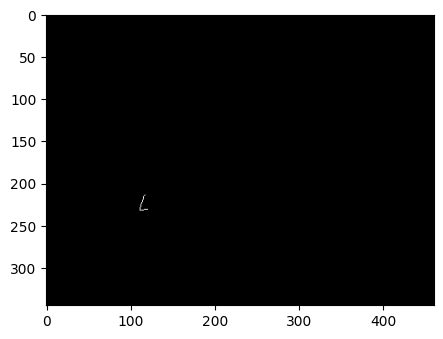

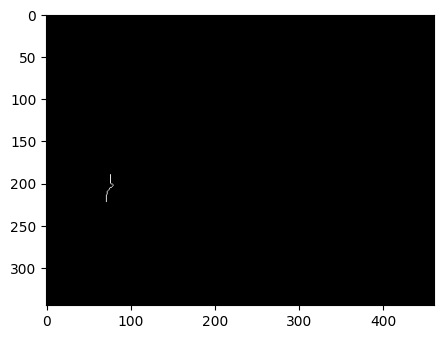

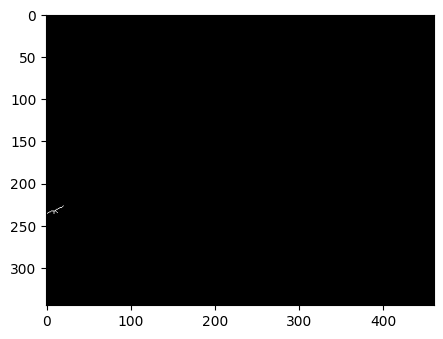

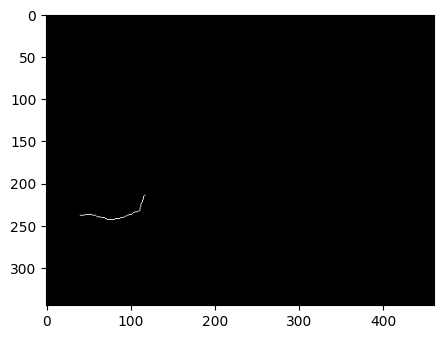

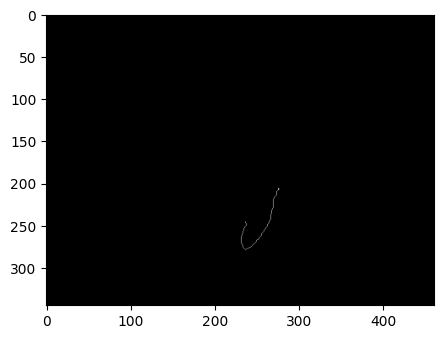

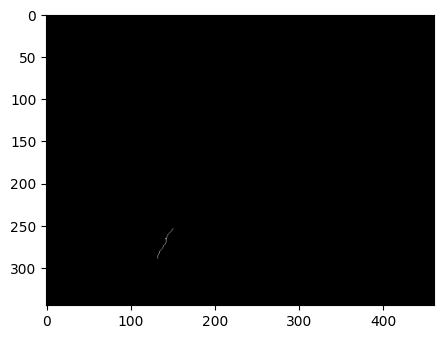

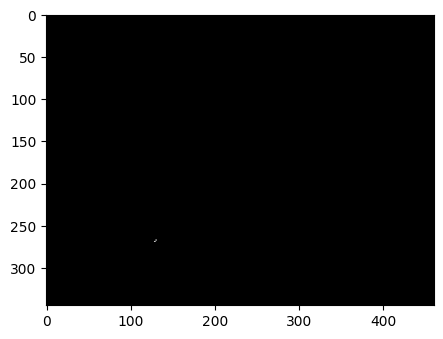

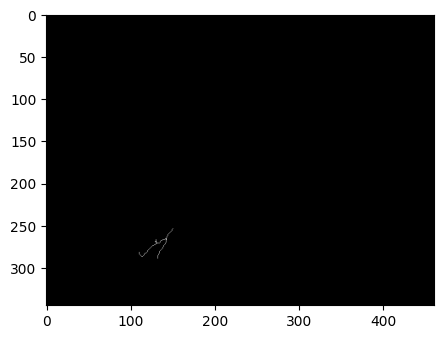

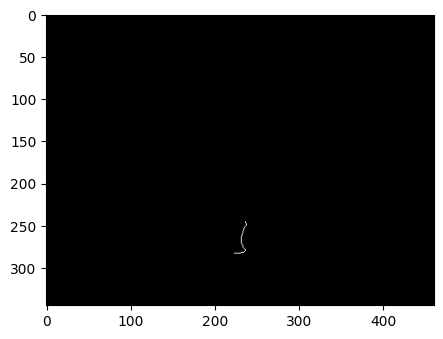

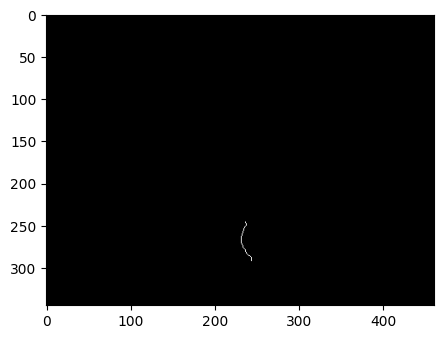

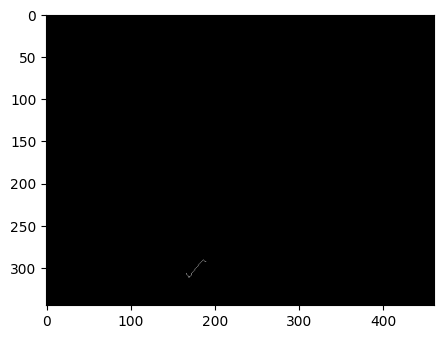

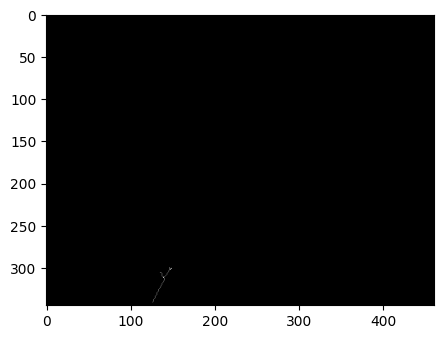

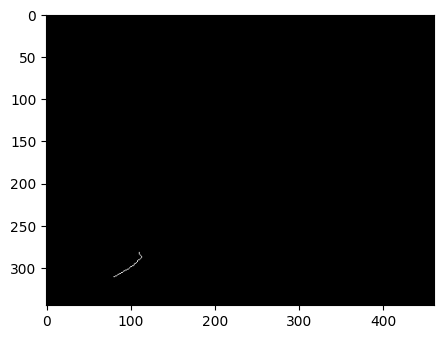

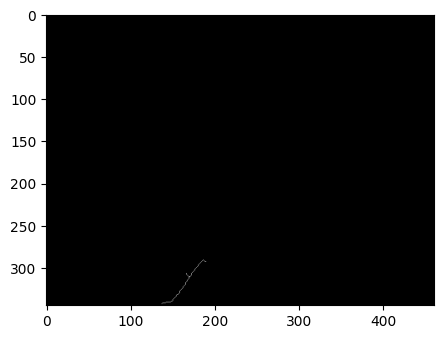

In [4]:
# Instance segmentation with shoot following

def get_connected_pixels(point, mask):
    neighbors = [
        (point[0] - 1, point[1] - 1), (point[0] - 1, point[1]), (point[0] - 1, point[1] + 1),
        (point[0], point[1] - 1),                             (point[0], point[1] + 1),
        (point[0] + 1, point[1] - 1), (point[0] + 1, point[1]), (point[0] + 1, point[1] + 1)
    ]
    return [p for p in neighbors if 0 <= p[0] < mask.shape[0] and 0 <= p[1] < mask.shape[1] and mask[p] == 1]

def direction(point1, point2):
    return (point2[0] - point1[0], point2[1] - point1[1])

def follow_shoot(mask, start_point, endpoints, used_endpoints, branching_points, crossing_points, visited_points=None, parent_direction=None):
    if visited_points is None:
        visited_points = set()

    instance = np.zeros_like(mask)
    current_point = start_point
    direction_vector = parent_direction or (0, 0)
    branch_points = []  # Store points where branching occurs

    while True:
        instance[current_point[0], current_point[1]] = 1
        visited_points.add(tuple(current_point))
        possible_points = get_connected_pixels(current_point, mask)

        # Remove already visited points
        possible_points = [p for p in possible_points if tuple(p) not in visited_points]

        if not possible_points:
            break

        # FIXME: This logic isn't working yet
        # Handle crossing points
        if tuple(current_point) in crossing_points:
            # Continue straight ahead, only consider the point in the current direction
            straight_points = sorted(possible_points, key=lambda p: np.dot(direction_vector, direction(current_point, p)), reverse=True)
            if straight_points:
                next_point = straight_points[0]
                direction_vector = direction(current_point, next_point)
                current_point = next_point
            else:
                break

        # Check for branching or overlap
        if len(possible_points) > 1 and tuple(current_point) in branching_points:
            # check if the current point is a branching point
            
            # Sort possible points by direction
            possible_points = sorted(possible_points, key=lambda p: np.dot(direction_vector, direction(current_point, p)), reverse=True)

            # Follow the main branch first
            next_point = possible_points[0]
            new_direction = direction(current_point, next_point)

            # Recursively follow the other branches
            for branch_point in possible_points[1:]:
                branch_direction = direction(current_point, branch_point)
                if tuple(branch_point) not in used_endpoints:
                    branch_points.append((branch_point, branch_direction))

            # Update current_point and direction_vector
            direction_vector = new_direction
            current_point = next_point
       
        else:
            next_point = possible_points[0]
            direction_vector = direction(current_point, next_point)
            current_point = next_point

        # Stop if we reach another endpoint
        if tuple(current_point) in endpoints:
            instance[current_point[0], current_point[1]] = 1
            used_endpoints.add(tuple(current_point))
            break

    # Follow the branches recursively
    for branch_point, branch_direction in branch_points:
        if tuple(branch_point) not in used_endpoints:
            instance += follow_shoot(mask, branch_point, endpoints, used_endpoints, branching_points, crossing_points, visited_points, branch_direction)

    return instance


instances = []
used_endpoints = set()

# Follow the shoot from the endpoint, assume that the most probable continuation is the pixel in front or on the corners in the direction of the shoot
# Get all the pixels connected to the point and get the one with the highest probability of being the continuation of the shoot
# Check if new pixel is inside endpoints, if it is then stop following the shoot
for endpoint in endpoints:
    if tuple(endpoint) in used_endpoints:
        continue
    # print(used_endpoints)
    instance = follow_shoot(skeletonised_mask, tuple(endpoint), set(map(tuple, endpoints)), used_endpoints, branching_points, crossing_points)
    instances.append(instance)
    used_endpoints.add(tuple(endpoint))


print(len(instances))

for i, instance in enumerate(instances):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(instance, cmap='gray')
    plt.show()